In [1]:
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the YOLOv8 model
model = YOLO("runs/barrel/yolov8n_custom/weights/best.pt")


image 1/1 c:\Users\dk\Desktop\barrel_detection\valid\images\PXL_20240705_130706817_jpg.rf.a0576127ed71b90c316c2c938a0bf9f7.jpg: 640x640 1 0_turret, 1 1_hull, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 72.7ms postprocess per image at shape (1, 3, 640, 640)


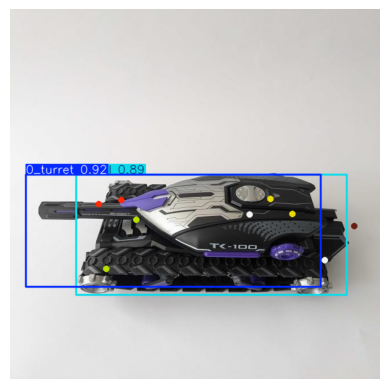

In [2]:
# Define the path or URL to the image
image_path = "valid/images/PXL_20240705_130706817_jpg.rf.a0576127ed71b90c316c2c938a0bf9f7.jpg" # should be test image, not valid image (used for testing as there is no test image)

# Run inference on the image
results = model(image_path)

# Get the first result (assuming only one image was passed)
result = results[0]

# Display the results
# Get the original image with bounding boxes and labels
result_img = result.plot() # This plots bounding boxes and labels on the image

# Convert the image from BGR to RGB
result_img_rgb = result_img[:, :, ::-1]

# Display the image
plt.imshow(result_img_rgb)
plt.axis('off') # Hide axes
plt.show()

In [3]:
# Retrieve and print the class names from the model
class_names = model.model.names
for class_index, class_name in class_names.items():
    print(f"Class {class_index}: {class_name}")

Class 0: 0_turret
Class 1: 1_hull


In [4]:
# Extract keypoints for the barrel and the tank
keypoints_data = result.keypoints.xy.cpu().numpy()

In [5]:
# Extracting kpt IDs with kpt coordinates
kp_with_id = [[(i, x, y) for i, (x, y) in enumerate(kp) if (x, y) != (0.0, 0.0)] for kp in keypoints_data]
display(kp_with_id)

[[(0, 153.64124, 337.01785),
  (1, 450.85718, 328.95575),
  (2, 414.2162, 355.46518),
  (3, 218.0868, 364.19257)],
 [(0, 192.04353, 330.56403),
  (1, 488.22897, 354.98108),
  (2, 544.5025, 434.77182),
  (3, 166.18379, 449.05716),
  (4, 595.5581, 375.10532)]]

In [6]:
# Assuming the first row is for the barrel and the second for the tank
turret_keypoints = keypoints_data[0]
hull_keypoints = keypoints_data[1]

In [7]:
# Extract the confidence scores
confidence_scores = result.keypoints.conf.cpu().numpy()  

In [8]:
# Extract the confidence scores for the hull keypoints from the second element of the confidence_scores list
hull_confidences = confidence_scores[1]

# Assign the confidence score for the top-right keypoint of the hull to a variable
confidence_kp_hull_topright = hull_confidences[0]

# Assign the confidence score for the bottom-right keypoint of the hull to a variable
confidence_kp_hull_bottomright = hull_confidences[1]

# Print the confidence scores
print(f"Confidence score for top-right keypoint: {confidence_kp_hull_topright }")
print(f"Confidence score for bottomright keypoint: {confidence_kp_hull_bottomright}")

Confidence score for top-right keypoint: 0.7583483457565308
Confidence score for bottomright keypoint: 0.73801189661026


In [9]:
# Extract the confidence scores for the turret keypoints from the first element of the confidence_scores list
turret_confidences = confidence_scores[0]

# Assign the confidence score for the intersection keypoint of the turret to a variable
confidence_kp_turret_intersection = turret_confidences[3]

# Assign the confidence score for the top keypoint of the turret to a variable
confidence_kp_turret_top = turret_confidences[1]

# Print the confidence scores
print(f"Confidence score for intersection keypoint: {confidence_kp_turret_intersection}")
print(f"Confidence score for top keypoint: {confidence_kp_turret_top}")

Confidence score for intersection keypoint: 0.6027112603187561
Confidence score for top keypoint: 0.7454795837402344


In [10]:
# Define the keypoints for barrel and tank
barrel_points = {
    "muzzle": turret_keypoints[0],
    "intersection": turret_keypoints[3] # alternatively, use turret_keypoints[1] for the "top" of the turret (it's more precise than the intersection as it is visible on all images)
}

tank_points = {
    "top-right": hull_keypoints[0],
    "bottom-right": hull_keypoints[1]
}

In [11]:
# Function to calculate the angle between two vectors
def calculate_angle(pt1, pt2, pt3, pt4):
    # Vector from pt1 to pt2 (barrel)
    vector1 = np.array(pt2) - np.array(pt1)
    # Vector from pt3 to pt4 (tank)
    vector2 = np.array(pt4) - np.array(pt3)

    # Calculate the angle between two vectors
    unit_vector1 = vector1 / np.linalg.norm(vector1)
    unit_vector2 = vector2 / np.linalg.norm(vector2)
    dot_product = np.dot(unit_vector1, unit_vector2)
    angle = np.arccos(dot_product)

    # Convert from radians to degrees
    angle = np.degrees(angle)
    return angle

In [12]:
# Calculate the rotation angle between the barrel and the tank
angle = calculate_angle(barrel_points["muzzle"], barrel_points["intersection"], tank_points["top-right"], tank_points["bottom-right"])

# Print the end barrel as a vector
print(f"Barrel vector: Barrel end (Muzzle) ({barrel_points['muzzle'][0]:.2f}, {barrel_points['muzzle'][1]:.2f}), Barrel start ({barrel_points['intersection'][0]:.2f}, {barrel_points['intersection'][1]:.2f})")

# Print the rotation angle
print(f"Estimated Rotation Angle: {angle:.2f} degrees")

# Determine the direction of the barrel relative to the hull
if angle == 0:
    print("The barrel is pointing at the front of the hull.")
elif angle == 180 or angle == -180:
    print("The barrel is pointing at the rear of the hull.")
elif angle > 0:
    print(f"The barrel is oriented {angle:.2f} degrees to the right of the hull.")
else: # angle < 0
    print(f"The barrel is oriented {abs(angle):.2f} degrees to the left of the hull.")

# Assuming barrel_points dictionary contains the points 'muzzle' and 'intersection'
muzzle_x, muzzle_y = barrel_points['muzzle']
intersection_x, intersection_y = barrel_points['intersection']

# Calculate the orientation vector components
orientation_vector_x = muzzle_x - intersection_x
orientation_vector_y = muzzle_y - intersection_y

# Print the orientation vector
print(f"Barrel Orientation vector: ({orientation_vector_x:.2f}, {orientation_vector_y:.2f})")

Barrel vector: Barrel end (Muzzle) (153.64, 337.02), Barrel start (218.09, 364.19)
Estimated Rotation Angle: 18.15 degrees
The barrel is oriented 18.15 degrees to the right of the hull.
Barrel Orientation vector: (-64.45, -27.17)
